Loading train/test...
Training rows: 52970, Test rows: 10540
Features used: 23
Training XGBoost...
[0]	train-mae:57.46841	eval-mae:56.26755
[50]	train-mae:8.96373	eval-mae:10.15594
[100]	train-mae:5.36791	eval-mae:7.53787
[150]	train-mae:4.81186	eval-mae:7.54012
[200]	train-mae:4.49703	eval-mae:7.58547
[219]	train-mae:4.39901	eval-mae:7.61116
Accuracy: 0.9598
MAE: 7.6112
RMSE: 15.6751
XGBoost training complete ✔
Saved -> ..\data\model_xgb.json
Saved metrics -> ..\data\xgb_metrics.txt
Saved feature importance -> ..\data\xgb_feature_importance.csv
Saved plot -> ..\data\actual_vs_pred_xgb.png


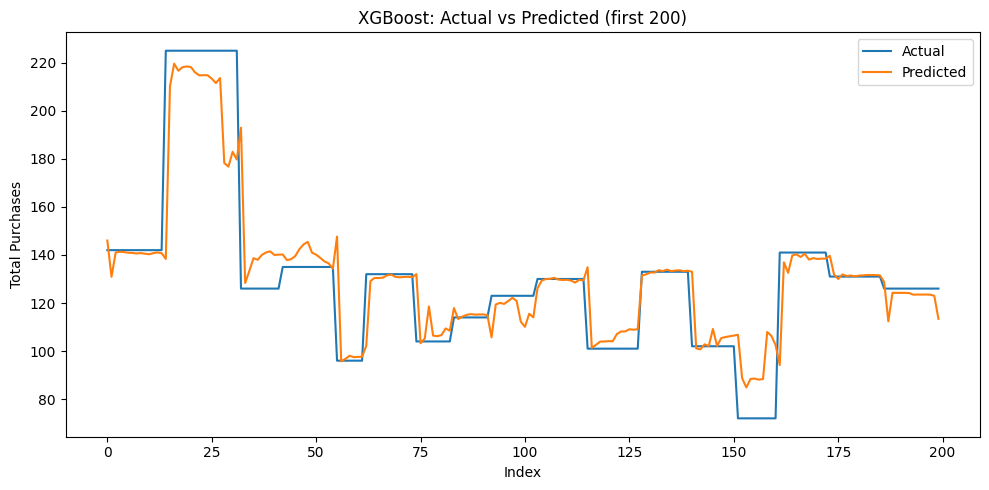

In [3]:
"""
XGBoost Training Script (Fixed for older XGBoost versions)
Uses final_train_v3.csv and final_test_v3.csv
Outputs:
 - model_xgb.json
 - xgb_metrics.txt
 - xgb_feature_importance.csv
 - actual_vs_pred_xgb.png
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

TRAIN_PATH = Path("../data/final_train_v3.csv")
TEST_PATH = Path("../data/final_test_v3.csv")
MODEL_OUT = Path("../data/model_xgb.json")
METRIC_OUT = Path("../data/xgb_metrics.txt")
FI_OUT = Path("../data/xgb_feature_importance.csv")
PLOT_OUT = Path("../data/actual_vs_pred_xgb.png")

print("Loading train/test...")
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

TARGET = "Total_Purchases"
blacklist = ["Date", "products_grouped", "Product_Category", "Country"]
features = [c for c in train.columns if c not in blacklist + [TARGET]]

X_train = train[features]
y_train = train[TARGET]
X_test = test[features]
y_test = test[TARGET]

print(f"Training rows: {len(X_train)}, Test rows: {len(X_test)}")
print(f"Features used: {len(features)}")

# -----------------------
# XGBoost Parameters
# -----------------------
params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.9,
    "colsample_bytree": 0.9
}

# Convert to DMatrix (works on all XGBoost versions)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# -----------------------
# Train Model (compatible with ALL versions)
# -----------------------
print("Training XGBoost...")
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1500,
    early_stopping_rounds=100,
    evals=watchlist,
    verbose_eval=50
)

# -----------------------
# Predictions
# -----------------------
preds = model.predict(dtest)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
accuracy = max(0.0, 1 - (mae / (y_test.mean() + 1e-9)))

print(f"Accuracy: {accuracy:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

with open(METRIC_OUT, "w") as f:
    f.write(f"Accuracy: {accuracy}\nMAE: {mae}\nRMSE: {rmse}\n")

# -----------------------
# Feature Importance
# -----------------------
fi_dict = model.get_score(importance_type='gain')
fi = pd.DataFrame(list(fi_dict.items()), columns=["feature", "importance"])
fi = fi.sort_values("importance", ascending=False)
fi.to_csv(FI_OUT, index=False)

# -----------------------
# Actual vs Predicted Plot
# -----------------------
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(preds[:200], label='Predicted')
plt.legend()
plt.title('XGBoost: Actual vs Predicted (first 200)')
plt.xlabel('Index')
plt.ylabel('Total Purchases')
plt.tight_layout()
plt.savefig(PLOT_OUT)

# -----------------------
# Save model
# -----------------------
model.save_model(str(MODEL_OUT))
print("XGBoost training complete ✔")
print(f"Saved -> {MODEL_OUT}")
print(f"Saved metrics -> {METRIC_OUT}")
print(f"Saved feature importance -> {FI_OUT}")
print(f"Saved plot -> {PLOT_OUT}")